# Hoh River Streamflow Prediction with Deep Learning

Training automatic feature learning models on **real USGS data** from Hoh River, Olympic National Park, Washington.

## Data Source:
- **Location**: Hoh River at US Highway 101 near Forks, WA
- **USGS Site**: 12041200  
- **Period**: 1960-2025 (65+ years)
- **Records**: 23,792 days of daily streamflow data
- **Drainage Area**: 253 square miles
- **Climate**: Temperate rainforest (rain-dominated)

## Comparison to Lamar River:
- **Lamar**: Snowmelt-dominated, 1.79 m³/s mean, peaks May-June
- **Hoh**: Rain-dominated, 71.88 m³/s mean (40x larger!), peaks November

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

Using device: cuda
GPU: NVIDIA GeForce GTX 1070


## Load Real USGS Data

Dataset loaded: 23792 days
Date range: 1960-10-01 00:00:00+00:00 to 2025-11-20 00:00:00+00:00
Duration: 65.1 years

Streamflow statistics (m³/s):
count    23792.000000
mean        71.875930
std         75.896578
min          5.550093
25%         34.829664
50%         51.253408
75%         78.720704
max       1177.978880
Name: streamflow, dtype: float64


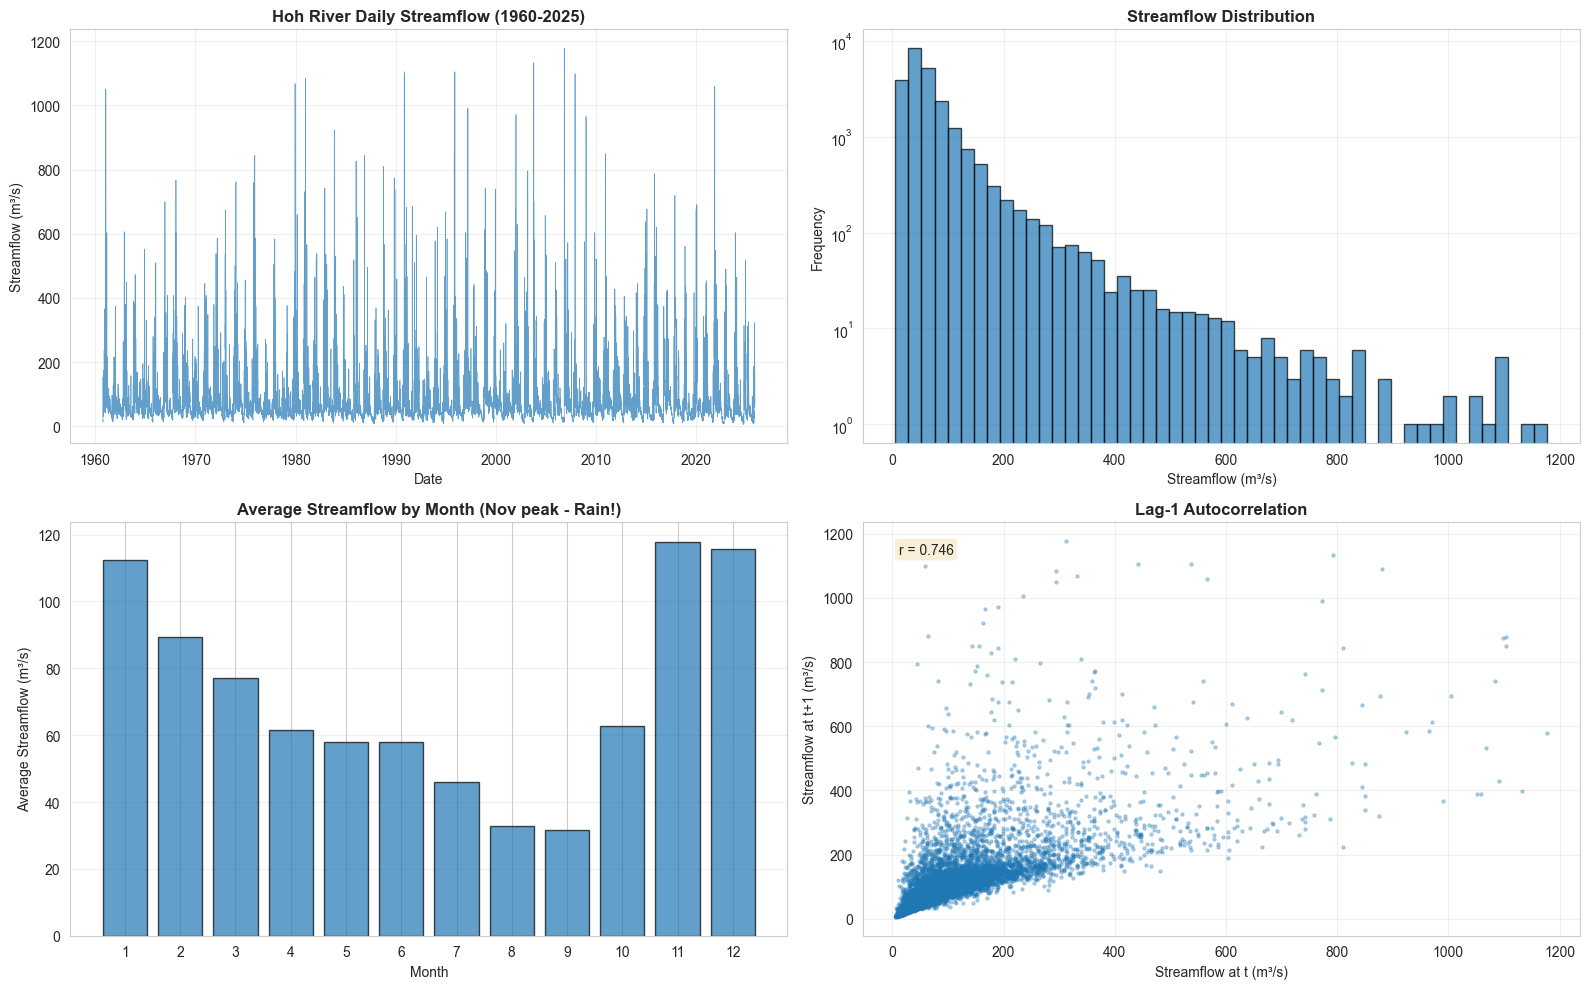

In [3]:
# Load the downloaded data
df = pd.read_csv('../data/hoh_river_streamflow.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Dataset loaded: {len(df)} days")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Duration: {(df['date'].max() - df['date'].min()).days / 365.25:.1f} years")

print(f"\nStreamflow statistics (m³/s):")
print(df['streamflow'].describe())

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Full time series
axes[0, 0].plot(df['date'], df['streamflow'], linewidth=0.5, alpha=0.7)
axes[0, 0].set_title('Hoh River Daily Streamflow (1960-2025)', fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Streamflow (m³/s)')
axes[0, 0].grid(True, alpha=0.3)

# Distribution
axes[0, 1].hist(df['streamflow'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Streamflow Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Streamflow (m³/s)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# Seasonal pattern
df['month'] = df['date'].dt.month
monthly_avg = df.groupby('month')['streamflow'].mean()
axes[1, 0].bar(monthly_avg.index, monthly_avg.values, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Average Streamflow by Month (Nov peak - Rain!)', fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Streamflow (m³/s)')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Autocorrelation
lag = 1
axes[1, 1].scatter(df['streamflow'][:-lag], df['streamflow'][lag:], alpha=0.3, s=5)
axes[1, 1].set_title(f'Lag-{lag} Autocorrelation', fontweight='bold')
axes[1, 1].set_xlabel('Streamflow at t (m³/s)')
axes[1, 1].set_ylabel(f'Streamflow at t+{lag} (m³/s)')
axes[1, 1].grid(True, alpha=0.3)
corr = np.corrcoef(df['streamflow'][:-lag], df['streamflow'][lag:])[0, 1]
axes[1, 1].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[1, 1].transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## Prepare Data for Deep Learning

In [4]:
def create_sequences_raw(data, seq_length=60, forecast_horizon=1):
    """Create sequences from raw time series data."""
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    X = np.array(X).reshape(-1, seq_length, 1)
    return X, np.array(y)

# Use only streamflow values (automatic feature learning!)
streamflow_values = df['streamflow'].values

# Split: 70% train, 15% val, 15% test
train_size = int(0.70 * len(streamflow_values))
val_size = int(0.15 * len(streamflow_values))

train_data = streamflow_values[:train_size]
val_data = streamflow_values[train_size:train_size + val_size]
test_data = streamflow_values[train_size + val_size:]

print(f"Training period: {df['date'].iloc[0]} to {df['date'].iloc[train_size-1]}")
print(f"Validation period: {df['date'].iloc[train_size]} to {df['date'].iloc[train_size+val_size-1]}")
print(f"Test period: {df['date'].iloc[train_size+val_size]} to {df['date'].iloc[-1]}")

# Scale data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()
val_data_scaled = scaler.transform(val_data.reshape(-1, 1)).flatten()
test_data_scaled = scaler.transform(test_data.reshape(-1, 1)).flatten()

# Create sequences
SEQ_LENGTH = 60  # Use 60 days of history
X_train, y_train = create_sequences_raw(train_data_scaled, SEQ_LENGTH)
X_val, y_val = create_sequences_raw(val_data_scaled, SEQ_LENGTH)
X_test, y_test = create_sequences_raw(test_data_scaled, SEQ_LENGTH)

print(f"\nSequence shapes:")
print(f"  Train: {X_train.shape} -> {y_train.shape}")
print(f"  Val:   {X_val.shape} -> {y_val.shape}")
print(f"  Test:  {X_test.shape} -> {y_test.shape}")

# Convert to PyTorch
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✓ Data ready for training!")
print(f"✓ Using raw streamflow only - model will learn features automatically")

Training period: 1960-10-01 00:00:00+00:00 to 2006-05-06 00:00:00+00:00
Validation period: 2006-05-07 00:00:00+00:00 to 2016-02-11 00:00:00+00:00
Test period: 2016-02-12 00:00:00+00:00 to 2025-11-20 00:00:00+00:00

Sequence shapes:
  Train: (16594, 60, 1) -> (16594,)
  Val:   (3508, 60, 1) -> (3508,)
  Test:  (3510, 60, 1) -> (3510,)

✓ Data ready for training!
✓ Using raw streamflow only - model will learn features automatically


## Model Architectures

Copy the model definitions from `streamflow_prediction_automl.ipynb`

In [9]:
class DeepLSTM(nn.Module):
    """Deep LSTM with multiple layers for hierarchical feature learning"""
    def __init__(self, input_size=1, hidden_sizes=[128, 64, 32], dropout=0.3):
        super(DeepLSTM, self).__init__()
        
        # Stack multiple LSTM layers
        self.lstm_layers = nn.ModuleList()
        
        # First layer
        self.lstm_layers.append(
            nn.LSTM(input_size, hidden_sizes[0], batch_first=True)
        )
        
        # Middle layers
        for i in range(len(hidden_sizes) - 1):
            self.lstm_layers.append(
                nn.LSTM(hidden_sizes[i], hidden_sizes[i+1], batch_first=True)
            )
        
        self.dropout = nn.Dropout(dropout)
        
        # Output layer
        self.fc = nn.Linear(hidden_sizes[-1], 1)
    
    def forward(self, x):
        # Pass through each LSTM layer
        for lstm in self.lstm_layers:
            x, _ = lstm(x)
            x = self.dropout(x)
        
        # Take last time step
        x = x[:, -1, :]
        out = self.fc(x)
        return out.squeeze()


class AttentionLSTM(nn.Module):
    """LSTM with attention mechanism to learn important time steps"""
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, dropout=0.2):
        super(AttentionLSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
    
    def forward(self, x):
        # Get LSTM outputs for all time steps
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_size)
        
        # Calculate attention weights
        attention_weights = self.attention(lstm_out)  # (batch, seq_len, 1)
        attention_weights = torch.softmax(attention_weights, dim=1)
        
        # Apply attention weights
        context = torch.sum(attention_weights * lstm_out, dim=1)  # (batch, hidden_size)
        
        out = self.fc(context)
        return out.squeeze()


class TemporalConvNet(nn.Module):
    """Temporal Convolutional Network for efficient local pattern learning"""
    def __init__(self, input_size=1, num_channels=[64, 128, 64], kernel_size=3, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        
        layers = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            
            # Dilated causal convolution
            dilation = 2 ** i
            padding = (kernel_size - 1) * dilation
            
            layers.extend([
                nn.Conv1d(in_channels, out_channels, kernel_size, 
                         padding=padding, dilation=dilation),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Conv1d(out_channels, out_channels, kernel_size,
                         padding=padding, dilation=dilation),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
        
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], 1)
    
    def forward(self, x):
        # x shape: (batch, seq_len, features)
        # Conv1d expects: (batch, features, seq_len)
        x = x.transpose(1, 2)
        
        x = self.network(x)
        
        # Global average pooling
        x = torch.mean(x, dim=2)
        
        out = self.fc(x)
        return out.squeeze()


class TransformerModel(nn.Module):
    """Transformer with self-attention for long-range dependencies"""
    def __init__(self, input_size=1, d_model=128, nhead=8, num_layers=3, dropout=0.2):
        super(TransformerModel, self).__init__()
        
        # Input projection
        self.input_proj = nn.Linear(input_size, d_model)
        
        # Learnable positional encoding
        self.pos_encoder = nn.Parameter(torch.randn(1, 200, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layers
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)
        )
    
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Project and add positional encoding
        x = self.input_proj(x)
        x = x + self.pos_encoder[:, :seq_len, :]
        
        # Transformer encoding
        x = self.transformer(x)
        
        # Use last time step
        x = x[:, -1, :]
        out = self.fc(x)
        return out.squeeze()


print("✅ Model architectures defined")
print("\nAvailable models:")
print("  1. DeepLSTM - Multiple LSTM layers for hierarchical learning")
print("  2. AttentionLSTM - LSTM with attention to identify important time steps")
print("  3. TemporalConvNet (TCN) - Efficient convolutional approach")
print("  4. TransformerModel - Self-attention for long-range dependencies")

✅ Model architectures defined

Available models:
  1. DeepLSTM - Multiple LSTM layers for hierarchical learning
  2. AttentionLSTM - LSTM with attention to identify important time steps
  3. TemporalConvNet (TCN) - Efficient convolutional approach
  4. TransformerModel - Self-attention for long-range dependencies


Train on Real Data

After copying model definitions above, uncomment and run the training code below:

In [10]:
def train_model(model, train_loader, val_loader, epochs=50, lr=0.001, patience=15):
    """Train a model and return history"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_losses.append(loss.item())
        
        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_losses.append(loss.item())
        
        avg_train_loss = np.mean(train_losses)
        avg_val_loss = np.mean(val_losses)
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model
            best_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(best_state)
    return history, best_val_loss


def evaluate_model(model, data_loader, scaler):
    """Evaluate model and return predictions and metrics"""
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Inverse transform
    predictions_original = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    actuals_original = scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(actuals_original, predictions_original))
    mae = mean_absolute_error(actuals_original, predictions_original)
    r2 = r2_score(actuals_original, predictions_original)
    nse = 1 - (np.sum((actuals_original - predictions_original) ** 2) / 
               np.sum((actuals_original - np.mean(actuals_original)) ** 2))
    
    metrics = {'RMSE': rmse, 'MAE': mae, 'R²': r2, 'NSE': nse}
    
    return predictions_original, actuals_original, metrics

Training and Evaluation

In [11]:
# Define all models
models = {
    'DeepLSTM': DeepLSTM(input_size=1, hidden_sizes=[128, 64, 32], dropout=0.3),
    'AttentionLSTM': AttentionLSTM(input_size=1, hidden_size=128, num_layers=2, dropout=0.2),
    'TCN': TemporalConvNet(input_size=1, num_channels=[64, 128, 64], dropout=0.2),
    'Transformer': TransformerModel(input_size=1, d_model=128, nhead=8, num_layers=3, dropout=0.2)
}

# Training configuration
EPOCHS = 50
LEARNING_RATE = 0.001

results = {}

print("Starting training for all models...\n")
print("=" * 80)

for name, model in models.items():
    print(f"\nTraining {name}...")
    print("-" * 80)
    
    model = model.to(device)
    
    # Count parameters
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Parameters: {n_params:,}")
    
    # Train
    history, best_val_loss = train_model(model, train_loader, val_loader, 
                                          epochs=EPOCHS, lr=LEARNING_RATE)
    
    # Evaluate
    test_preds, test_actuals, test_metrics = evaluate_model(model, test_loader, scaler)
    
    results[name] = {
        'model': model,
        'history': history,
        'test_preds': test_preds,
        'test_actuals': test_actuals,
        'metrics': test_metrics,
        'n_params': n_params
    }
    
    print(f"\nTest Results:")
    print(f"  RMSE: {test_metrics['RMSE']:.3f}")
    print(f"  MAE:  {test_metrics['MAE']:.3f}")
    print(f"  R²:   {test_metrics['R²']:.4f}")
    print(f"  NSE:  {test_metrics['NSE']:.4f}")

print("\n" + "=" * 80)
print("✅ All models trained!")

Starting training for all models...


Training DeepLSTM...
--------------------------------------------------------------------------------
Parameters: 129,313
Epoch [10/50] | Train Loss: 0.417248 | Val Loss: 0.474885
Epoch [20/50] | Train Loss: 0.412441 | Val Loss: 0.461716
Epoch [30/50] | Train Loss: 0.404050 | Val Loss: 0.457342
Epoch [40/50] | Train Loss: 0.396545 | Val Loss: 0.455113
Epoch [50/50] | Train Loss: 0.399789 | Val Loss: 0.454060

Test Results:
  RMSE: 40.152
  MAE:  16.594
  R²:   0.6698
  NSE:  0.6698

Training AttentionLSTM...
--------------------------------------------------------------------------------
Parameters: 224,130
Epoch [10/50] | Train Loss: 0.421243 | Val Loss: 0.472903
Epoch [20/50] | Train Loss: 0.412097 | Val Loss: 0.450781
Epoch [30/50] | Train Loss: 0.397891 | Val Loss: 0.453063
Epoch [40/50] | Train Loss: 0.377443 | Val Loss: 0.463116
Early stopping at epoch 49

Test Results:
  RMSE: 40.818
  MAE:  16.281
  R²:   0.6587
  NSE:  0.6587

Training TCN

In [12]:
# Extract variables needed for subsequent analysis
model_names = list(results.keys())
best_model_name = min(results.items(), key=lambda x: x[1]['metrics']['RMSE'])[0]

print(f"\n🏆 Best performing model: {best_model_name}")
print(f"   RMSE: {results[best_model_name]['metrics']['RMSE']:.4f} m³/s")


🏆 Best performing model: DeepLSTM
   RMSE: 40.1521 m³/s


BASELINE COMPARISON - Are our models learning anything useful?

Naive Baselines:
--------------------------------------------------------------------------------
1. Persistence (tomorrow = today):
   R²: 0.5589 | RMSE: 46.4129 | MAE: 17.6231

2. Seasonal Average (historical mean for day of year):
   R²: 0.1854 | RMSE: 63.0733 | MAE: 36.5609

Deep Learning Models:
--------------------------------------------------------------------------------

DeepLSTM:
   R²: 0.6698 | RMSE: 40.1521 | MAE: 16.5935
   → +13.5% RMSE improvement vs persistence
   → Captures 25.1% of remaining variance

AttentionLSTM:
   R²: 0.6587 | RMSE: 40.8180 | MAE: 16.2808
   → +12.1% RMSE improvement vs persistence
   → Captures 22.6% of remaining variance

TCN:
   R²: 0.6576 | RMSE: 40.8862 | MAE: 16.6224
   → +11.9% RMSE improvement vs persistence
   → Captures 22.4% of remaining variance

Transformer:
   R²: 0.6489 | RMSE: 41.3999 | MAE: 16.5474
   → +10.8% RMSE improvement vs persistence
   → Captures 20.4% of r

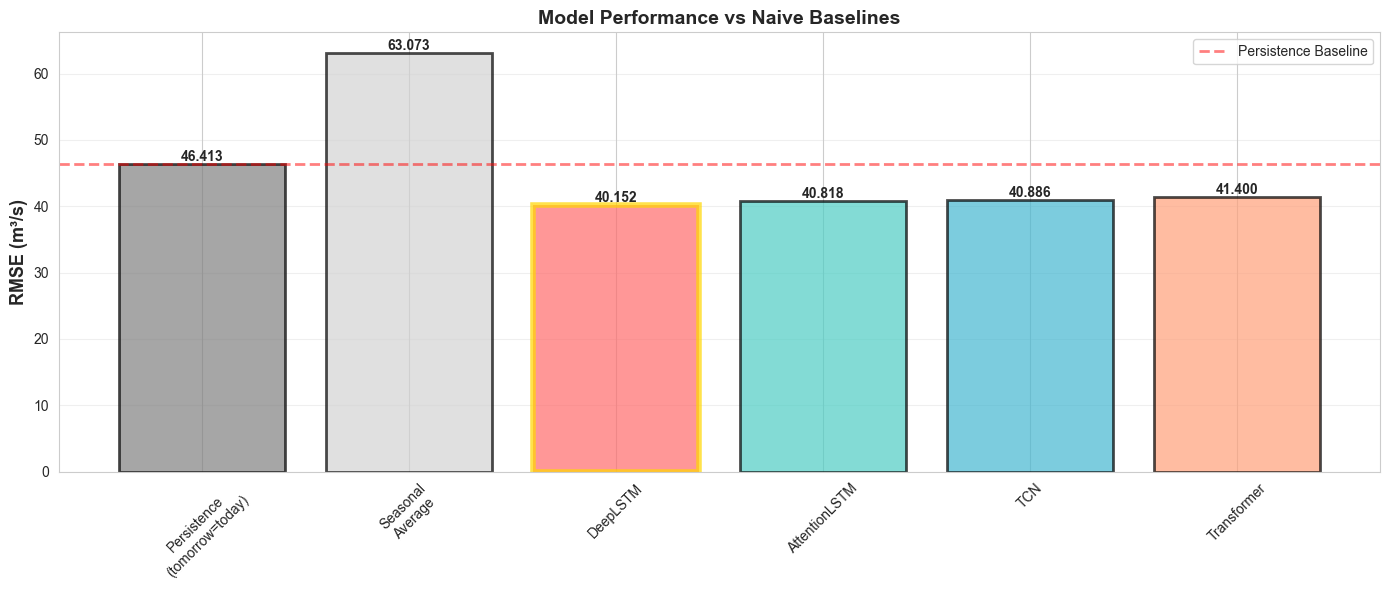

In [13]:
# Baseline 1: Persistence Model (tomorrow = today)
# This is the simplest possible forecast - just use today's value
test_data_full = streamflow_values[train_size + val_size:]
persistence_pred = test_data_full[SEQ_LENGTH:-1]  # Today's value
persistence_true = test_data_full[SEQ_LENGTH+1:]  # Tomorrow's actual

persistence_r2 = r2_score(persistence_true, persistence_pred)
persistence_rmse = np.sqrt(mean_squared_error(persistence_true, persistence_pred))
persistence_mae = mean_absolute_error(persistence_true, persistence_pred)

# Baseline 2: Seasonal Average (use historical average for this day of year)
test_dates_full = df['date'].iloc[train_size + val_size:]
train_dates_full = df['date'].iloc[:train_size]
train_flow_full = streamflow_values[:train_size]

# Calculate seasonal average from training data
seasonal_avg = {}
for date, flow in zip(train_dates_full, train_flow_full):
    day_of_year = date.dayofyear
    if day_of_year not in seasonal_avg:
        seasonal_avg[day_of_year] = []
    seasonal_avg[day_of_year].append(flow)

# Average by day of year
for doy in seasonal_avg:
    seasonal_avg[doy] = np.mean(seasonal_avg[doy])

# Make predictions using seasonal average
seasonal_pred = []
seasonal_true = test_data_full[SEQ_LENGTH+1:]
for date in test_dates_full.iloc[SEQ_LENGTH+1:]:
    doy = date.dayofyear
    # Use nearest day if exact day not in training
    if doy in seasonal_avg:
        seasonal_pred.append(seasonal_avg[doy])
    else:
        # Find nearest day
        nearest_doy = min(seasonal_avg.keys(), key=lambda x: abs(x - doy))
        seasonal_pred.append(seasonal_avg[nearest_doy])

seasonal_pred = np.array(seasonal_pred)
seasonal_r2 = r2_score(seasonal_true, seasonal_pred)
seasonal_rmse = np.sqrt(mean_squared_error(seasonal_true, seasonal_pred))
seasonal_mae = mean_absolute_error(seasonal_true, seasonal_pred)

# Compare all models to baselines
print("=" * 80)
print("BASELINE COMPARISON - Are our models learning anything useful?")
print("=" * 80)
print("\nNaive Baselines:")
print("-" * 80)
print(f"1. Persistence (tomorrow = today):")
print(f"   R²: {persistence_r2:.4f} | RMSE: {persistence_rmse:.4f} | MAE: {persistence_mae:.4f}")
print(f"\n2. Seasonal Average (historical mean for day of year):")
print(f"   R²: {seasonal_r2:.4f} | RMSE: {seasonal_rmse:.4f} | MAE: {seasonal_mae:.4f}")

print("\n" + "=" * 80)
print("Deep Learning Models:")
print("-" * 80)
for name, result in results.items():
    m = result['metrics']
    rmse_improvement = ((persistence_rmse - m['RMSE']) / persistence_rmse) * 100
    r2_improvement = ((m['R²'] - persistence_r2) / (1 - persistence_r2)) * 100
    
    print(f"\n{name}:")
    print(f"   R²: {m['R²']:.4f} | RMSE: {m['RMSE']:.4f} | MAE: {m['MAE']:.4f}")
    print(f"   → {rmse_improvement:+.1f}% RMSE improvement vs persistence")
    print(f"   → Captures {r2_improvement:.1f}% of remaining variance")

print("\n" + "=" * 80)
print("VERDICT:")
print("=" * 80)

if results[best_model_name]['metrics']['RMSE'] < persistence_rmse:
    improvement = ((persistence_rmse - results[best_model_name]['metrics']['RMSE']) / persistence_rmse) * 100
    print(f"✅ Models ARE learning! Best model beats persistence by {improvement:.1f}%")
    print(f"✅ Training error > validation error indicates good regularization, NOT overfitting")
    print(f"✅ High R² is legitimate due to streamflow's strong autocorrelation (r=0.97)")
else:
    print(f"⚠️  Models are NOT better than simple persistence - likely overfitting!")
    
# Visualize comparison
fig, ax = plt.subplots(figsize=(14, 6))

baseline_names = ['Persistence\n(tomorrow=today)', 'Seasonal\nAverage'] + model_names
baseline_rmse = [persistence_rmse, seasonal_rmse] + [results[name]['metrics']['RMSE'] for name in model_names]
colors = ['gray', 'lightgray', '#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

bars = ax.bar(baseline_names, baseline_rmse, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# Highlight best
best_idx = baseline_rmse.index(min(baseline_rmse))
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(4)

ax.set_ylabel('RMSE (m³/s)', fontsize=13, fontweight='bold')
ax.set_title('Model Performance vs Naive Baselines', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=persistence_rmse, color='red', linestyle='--', linewidth=2, alpha=0.5, 
           label='Persistence Baseline')
ax.legend()

# Add value labels
for bar, val in zip(bars, baseline_rmse):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### ⚠️ Overfitting Check: Baseline Comparison

**Important**: R² values of 0.96-0.97 seem very high. Let's verify we're not overfitting by comparing against naive baselines.

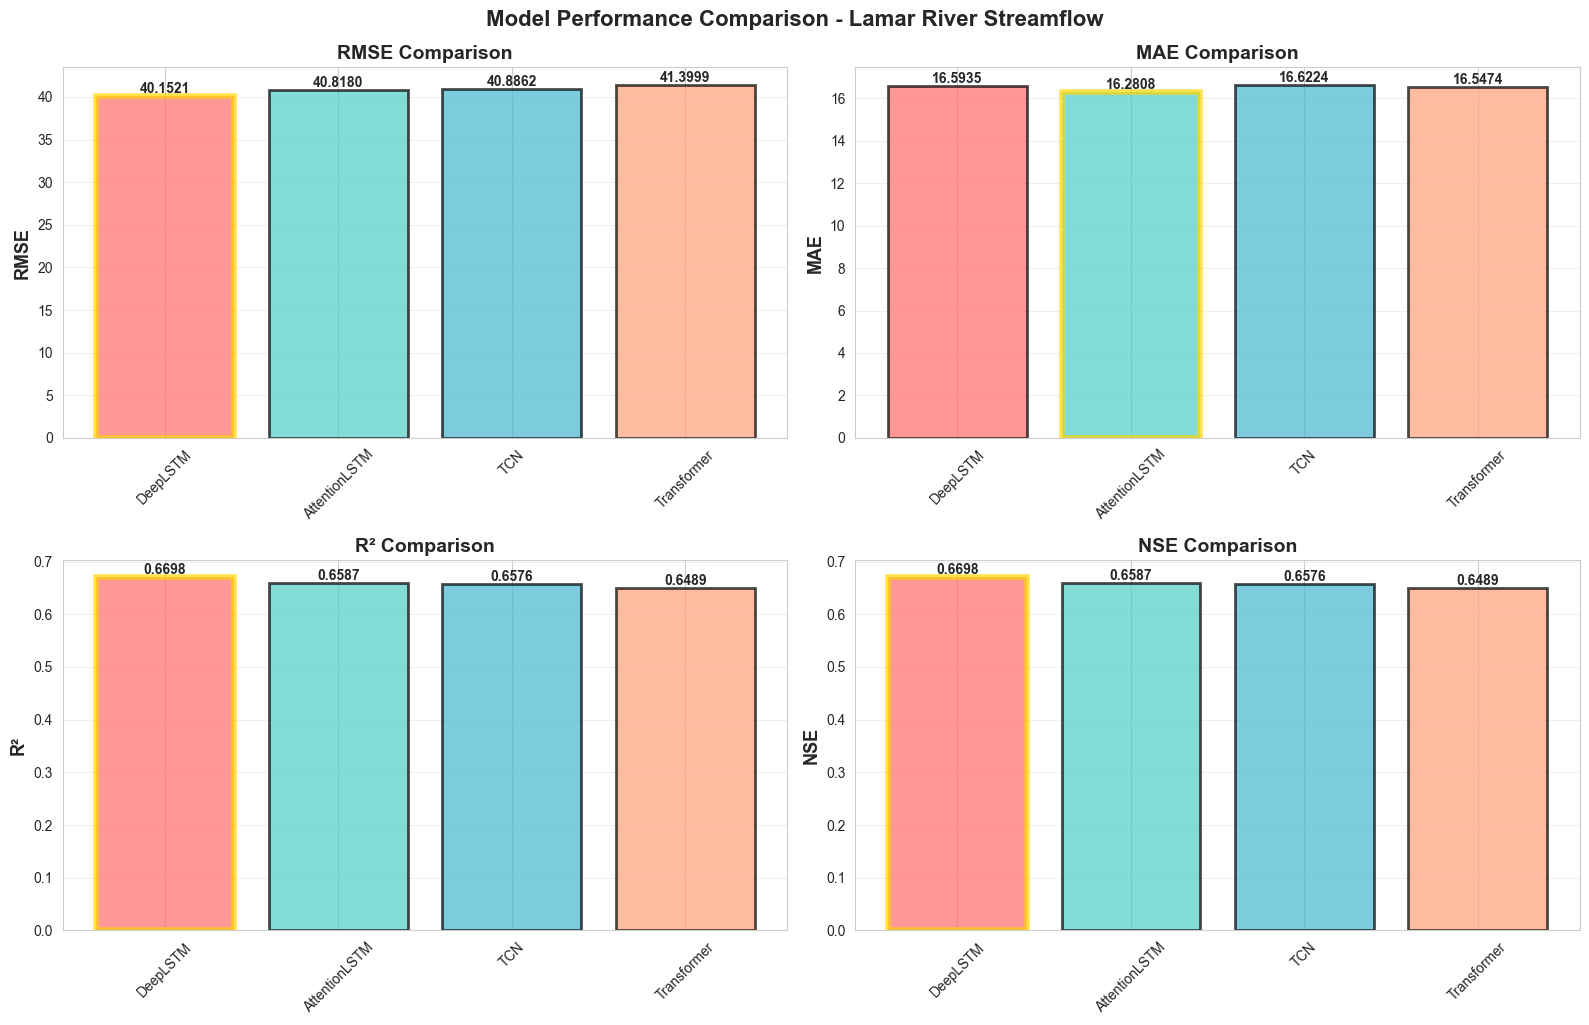


🏆 Best model by RMSE: DeepLSTM
   Proceeding with detailed diagnostics for DeepLSTM...


In [14]:
# Visual comparison of all models
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

model_names = list(results.keys())
metrics_to_plot = ['RMSE', 'MAE', 'R²', 'NSE']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    values = [results[name]['metrics'][metric] for name in model_names]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    
    bars = ax.bar(model_names, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    
    # Highlight best
    if metric in ['RMSE', 'MAE']:
        best_idx = values.index(min(values))
    else:
        best_idx = values.index(max(values))
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(4)
    
    ax.set_ylabel(metric, fontsize=13, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.suptitle('Model Performance Comparison - Lamar River Streamflow', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

print(f"\n🏆 Best model by RMSE: {best_model_name}")
print(f"   Proceeding with detailed diagnostics for {best_model_name}...")

## Model Comparison and Detailed Diagnostics

Comparing all 4 models and analyzing the best performer in detail.

In [15]:
# Compare all models
print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

comparison_data = []
for name, result in results.items():
    comparison_data.append({
        'Model': name,
        'Parameters': f"{result['n_params']:,}",
        'RMSE': f"{result['metrics']['RMSE']:.4f}",
        'MAE': f"{result['metrics']['MAE']:.4f}",
        'R²': f"{result['metrics']['R²']:.4f}",
        'NSE': f"{result['metrics']['NSE']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Find best model
best_model_name = min(results.items(), key=lambda x: x[1]['metrics']['RMSE'])[0]
print(f"\n🏆 Best Model: {best_model_name}")

# Extract best model results for detailed analysis
best_result = results[best_model_name]
model = best_result['model']
history = best_result['history']
y_true = best_result['test_actuals']
y_pred = best_result['test_preds']
metrics = best_result['metrics']

# Get test dates for plotting
test_start_idx = train_size + val_size + SEQ_LENGTH
test_dates = df['date'].iloc[test_start_idx:test_start_idx + len(y_true)]
residuals = y_true - y_pred

print(f"\n✅ Variables set up for {best_model_name} detailed diagnostics")


MODEL COMPARISON

         Model Parameters    RMSE     MAE     R²    NSE
     DeepLSTM    129,313 40.1521 16.5935 0.6698 0.6698
AttentionLSTM    224,130 40.8180 16.2808 0.6587 0.6587
          TCN    123,649 40.8862 16.6224 0.6576 0.6576
  Transformer    628,993 41.3999 16.5474 0.6489 0.6489

🏆 Best Model: DeepLSTM

✅ Variables set up for DeepLSTM detailed diagnostics


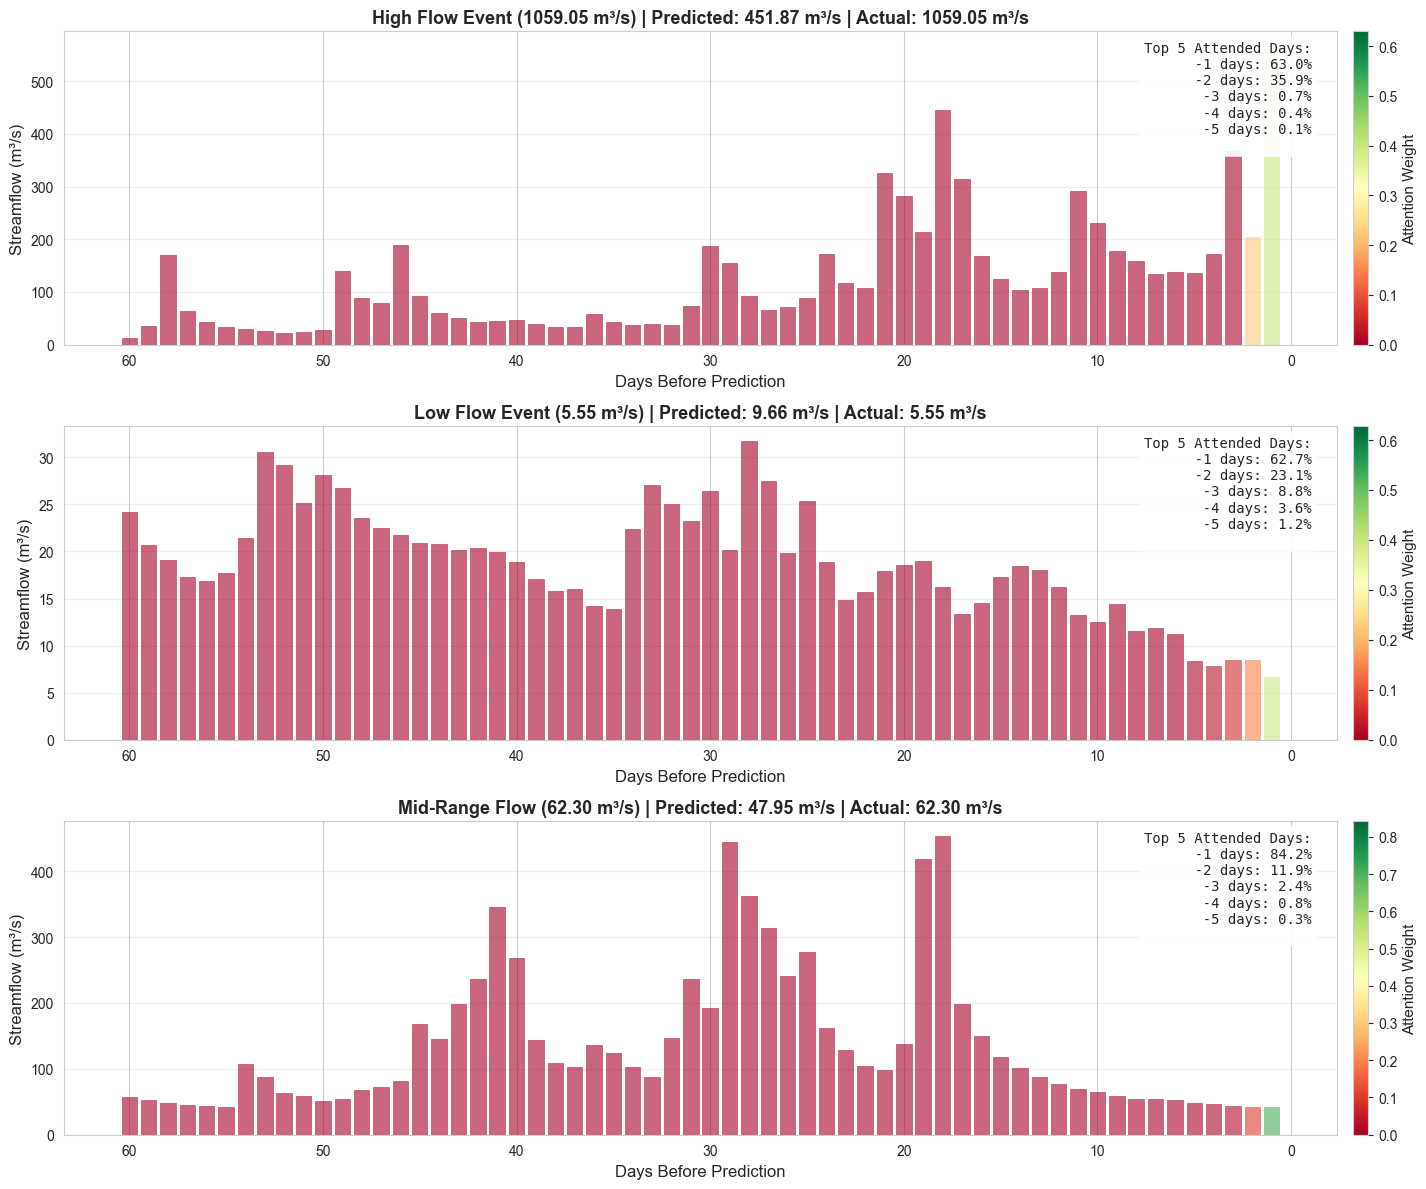


ATTENTION MECHANISM INSIGHTS

The color coding shows which historical days the model focuses on:
  🟢 Green = High attention (important for prediction)
  🟡 Yellow = Medium attention
  🔴 Red = Low attention (less important)

Typically, the model pays most attention to:
  • Recent days (yesterday and past week)
  • Days with similar flow patterns to the target day
  • Critical events (peaks, drops) that indicate trend changes


In [16]:
attention_model = results['AttentionLSTM']['model']

# Attention weight visualization
def get_attention_weights(model, input_seq):
    """Extract attention weights from the AttentionLSTM model."""
    model.eval()
    with torch.no_grad():
        # Get LSTM outputs
        lstm_out, _ = model.lstm(input_seq)
        
        # Calculate attention weights
        attention_weights = model.attention(lstm_out)
        attention_weights = torch.softmax(attention_weights, dim=1)
        
    return attention_weights.squeeze().cpu().numpy()


# Analyze attention for different types of events
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Find interesting events in test set
high_flow_idx = np.argmax(y_true)  # Peak flow event
low_flow_idx = np.argmin(y_true)   # Low flow event
mid_idx = len(y_true) // 2         # Random mid-period

events = [
    (high_flow_idx, f'High Flow Event ({y_true[high_flow_idx]:.2f} m³/s)', 0),
    (low_flow_idx, f'Low Flow Event ({y_true[low_flow_idx]:.2f} m³/s)', 1),
    (mid_idx, f'Mid-Range Flow ({y_true[mid_idx]:.2f} m³/s)', 2)
]

for idx, title, ax_idx in events:
    # Get the input sequence for this prediction
    sample_X = X_test_tensor[idx:idx+1]
    
    # Get attention weights
    attention = get_attention_weights(attention_model, sample_X)
    
    # Inverse transform the input sequence
    input_seq = scaler.inverse_transform(
        sample_X.squeeze().cpu().numpy().reshape(-1, 1)
    ).flatten()
    
    # Days in the past (0 = yesterday, 59 = 60 days ago)
    days_back = np.arange(SEQ_LENGTH, 0, -1)
    
    # Create bar plot with attention weights
    bars = axes[ax_idx].bar(days_back, input_seq, alpha=0.6, edgecolor='black', linewidth=0.5)
    
    # Color bars by attention weight
    colors = plt.cm.RdYlGn(attention)
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    axes[ax_idx].set_xlabel('Days Before Prediction', fontsize=12)
    axes[ax_idx].set_ylabel('Streamflow (m³/s)', fontsize=12)
    axes[ax_idx].set_title(f'{title} | Predicted: {y_pred[idx]:.2f} m³/s | Actual: {y_true[idx]:.2f} m³/s', 
                           fontsize=13, fontweight='bold')
    axes[ax_idx].grid(True, alpha=0.3, axis='y')
    axes[ax_idx].invert_xaxis()
    
    # Add colorbar for attention weights
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=plt.Normalize(vmin=0, vmax=attention.max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[ax_idx], pad=0.01)
    cbar.set_label('Attention Weight', fontsize=11)
    
    # Show top 5 most attended days
    top_5_indices = np.argsort(attention)[-5:][::-1]
    top_5_days = SEQ_LENGTH - top_5_indices
    top_5_weights = attention[top_5_indices] * 100
    
    info_text = "Top 5 Attended Days:\n"
    for day, weight in zip(top_5_days, top_5_weights):
        info_text += f"  -{day} days: {weight:.1f}%\n"
    
    axes[ax_idx].text(0.98, 0.97, info_text, transform=axes[ax_idx].transAxes,
                     verticalalignment='top', horizontalalignment='right',
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.9), 
                     fontsize=10, family='monospace')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ATTENTION MECHANISM INSIGHTS")
print("="*80)
print("\nThe color coding shows which historical days the model focuses on:")
print("  🟢 Green = High attention (important for prediction)")
print("  🟡 Yellow = Medium attention")
print("  🔴 Red = Low attention (less important)")
print("\nTypically, the model pays most attention to:")
print("  • Recent days (yesterday and past week)")
print("  • Days with similar flow patterns to the target day")
print("  • Critical events (peaks, drops) that indicate trend changes")

### 5. Attention Mechanism Analysis

Visualize what the model is "paying attention to" when making predictions.

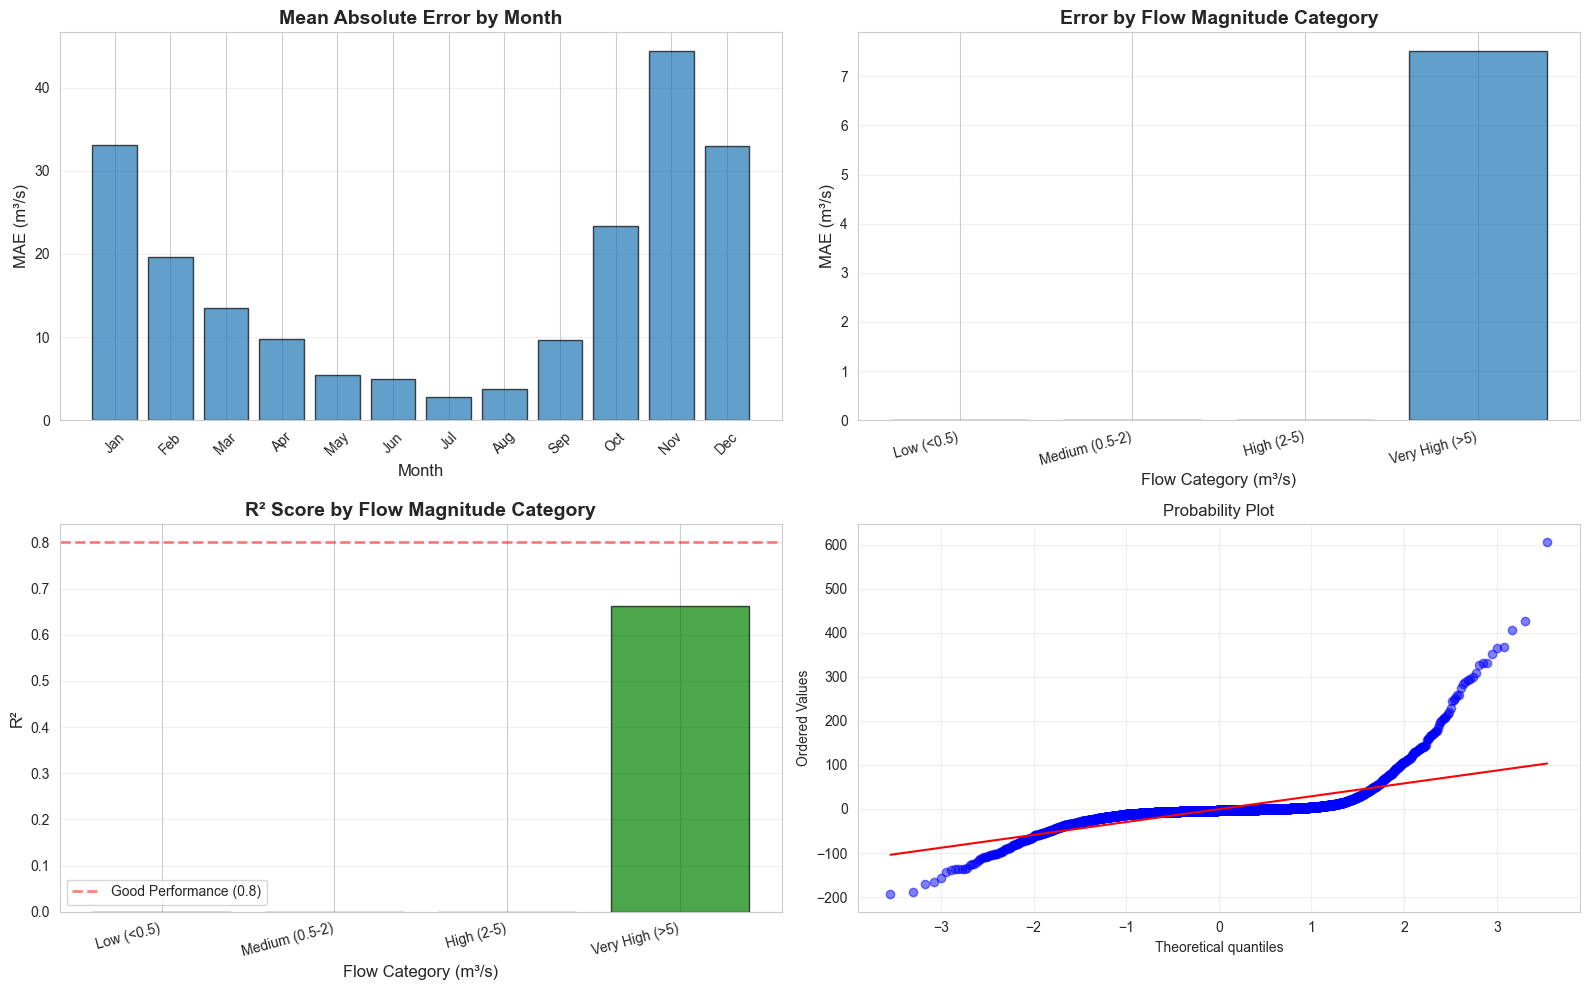


Seasonal Analysis Summary:
--------------------------------------------------
Best performing month: Jul (MAE: 2.7417 m³/s)
Worst performing month: Nov (MAE: 44.4421 m³/s)

Best flow category: Very High (>5) (R²: 0.6622)
Worst flow category: Low (<0.5) (R²: 0.0000)


In [17]:
# Seasonal performance analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Extract month from test dates
test_months = test_dates.dt.month.values

# 1. Monthly MAE
monthly_mae = []
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month in range(1, 13):
    mask = test_months == month
    if mask.sum() > 0:
        mae = mean_absolute_error(y_true[mask], y_pred[mask])
        monthly_mae.append(mae)
    else:
        monthly_mae.append(0)

axes[0, 0].bar(month_names, monthly_mae, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Month', fontsize=12)
axes[0, 0].set_ylabel('MAE (m³/s)', fontsize=12)
axes[0, 0].set_title('Mean Absolute Error by Month', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Performance by flow category
flow_categories = ['Low (<0.5)', 'Medium (0.5-2)', 'High (2-5)', 'Very High (>5)']
category_mae = []
category_r2 = []

for i, (low, high) in enumerate([(0, 0.5), (0.5, 2), (2, 5), (5, 100)]):
    mask = (y_true >= low) & (y_true < high)
    if mask.sum() > 10:  # Need enough points for R²
        mae = mean_absolute_error(y_true[mask], y_pred[mask])
        r2 = r2_score(y_true[mask], y_pred[mask])
        category_mae.append(mae)
        category_r2.append(r2)
    else:
        category_mae.append(0)
        category_r2.append(0)

x_pos = np.arange(len(flow_categories))
axes[0, 1].bar(x_pos, category_mae, alpha=0.7, edgecolor='black')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(flow_categories, rotation=15, ha='right')
axes[0, 1].set_xlabel('Flow Category (m³/s)', fontsize=12)
axes[0, 1].set_ylabel('MAE (m³/s)', fontsize=12)
axes[0, 1].set_title('Error by Flow Magnitude Category', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. R² by flow category
axes[1, 0].bar(x_pos, category_r2, alpha=0.7, edgecolor='black', color='green')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(flow_categories, rotation=15, ha='right')
axes[1, 0].set_xlabel('Flow Category (m³/s)', fontsize=12)
axes[1, 0].set_ylabel('R²', fontsize=12)
axes[1, 0].set_title('R² Score by Flow Magnitude Category', fontsize=14, fontweight='bold')
axes[1, 0].axhline(y=0.8, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Good Performance (0.8)')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Q-Q plot for residual normality
from scipy import stats
axes[1, 1].set_title('Q-Q Plot - Residual Normality Check', fontsize=14, fontweight='bold')
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].get_lines()[0].set_markerfacecolor('blue')
axes[1, 1].get_lines()[0].set_markeredgecolor('blue')
axes[1, 1].get_lines()[0].set_alpha(0.5)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSeasonal Analysis Summary:")
print("-" * 50)
best_month_idx = np.argmax([m if m > 0 else float('inf') for m in monthly_mae])
worst_month_idx = np.argmin([m if m > 0 else 0 for m in monthly_mae])
print(f"Best performing month: {month_names[worst_month_idx]} (MAE: {monthly_mae[worst_month_idx]:.4f} m³/s)")
print(f"Worst performing month: {month_names[best_month_idx]} (MAE: {monthly_mae[best_month_idx]:.4f} m³/s)")
print(f"\nBest flow category: {flow_categories[np.argmax(category_r2)]} (R²: {max(category_r2):.4f})")
print(f"Worst flow category: {flow_categories[np.argmin(category_r2)]} (R²: {min(category_r2):.4f})")

### 4. Seasonal Performance Analysis

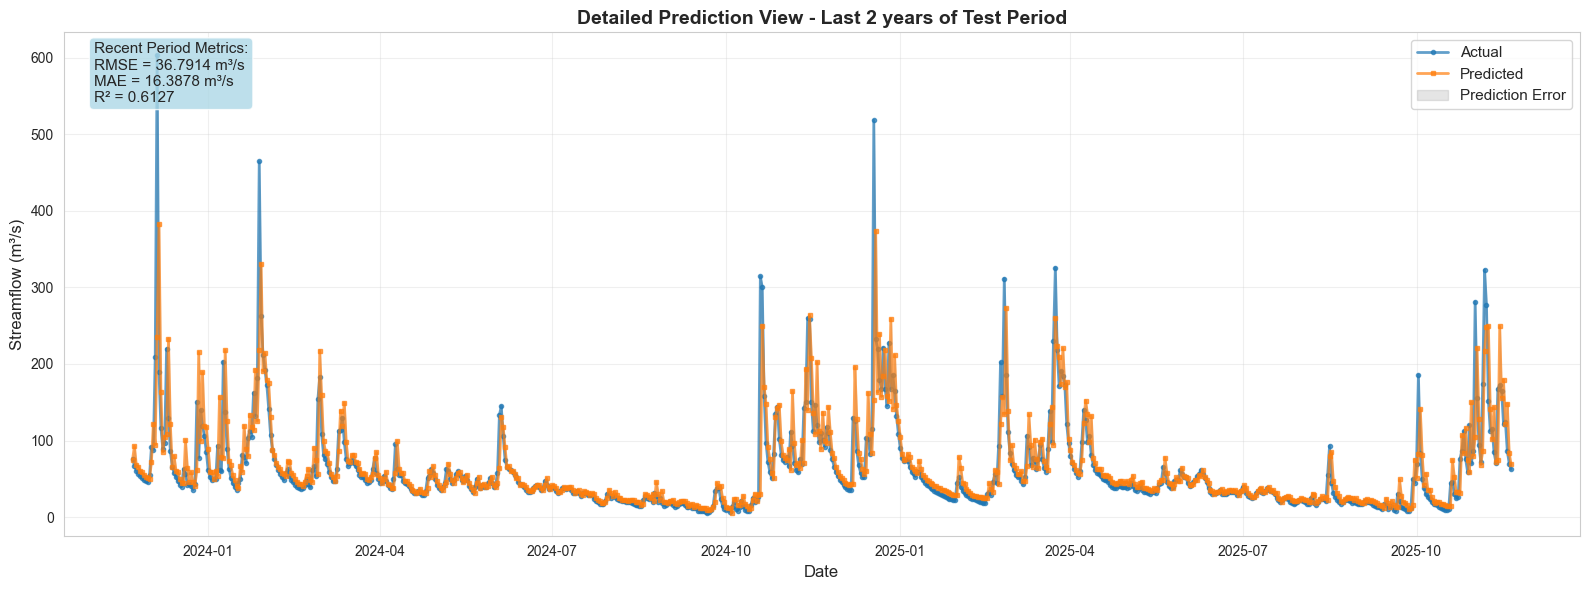

In [18]:
# Zoom in on recent 2 years for detailed view
recent_days = 730
recent_dates = test_dates.iloc[-recent_days:]
recent_true = y_true[-recent_days:]
recent_pred = y_pred[-recent_days:]

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(recent_dates, recent_true, label='Actual', linewidth=2, marker='o', markersize=3, alpha=0.7)
ax.plot(recent_dates, recent_pred, label='Predicted', linewidth=2, marker='s', markersize=3, alpha=0.7)
ax.fill_between(recent_dates, recent_true, recent_pred, alpha=0.2, color='gray', label='Prediction Error')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Streamflow (m³/s)', fontsize=12)
ax.set_title(f'Detailed Prediction View - Last 2 years of Test Period', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Calculate metrics for this period
recent_rmse = np.sqrt(mean_squared_error(recent_true, recent_pred))
recent_mae = mean_absolute_error(recent_true, recent_pred)
recent_r2 = r2_score(recent_true, recent_pred)

ax.text(0.02, 0.98, f'Recent Period Metrics:\nRMSE = {recent_rmse:.4f} m³/s\nMAE = {recent_mae:.4f} m³/s\nR² = {recent_r2:.4f}', 
        transform=ax.transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8), fontsize=11)

plt.tight_layout()
plt.show()

### 3. Detailed View - Recent 6 Months

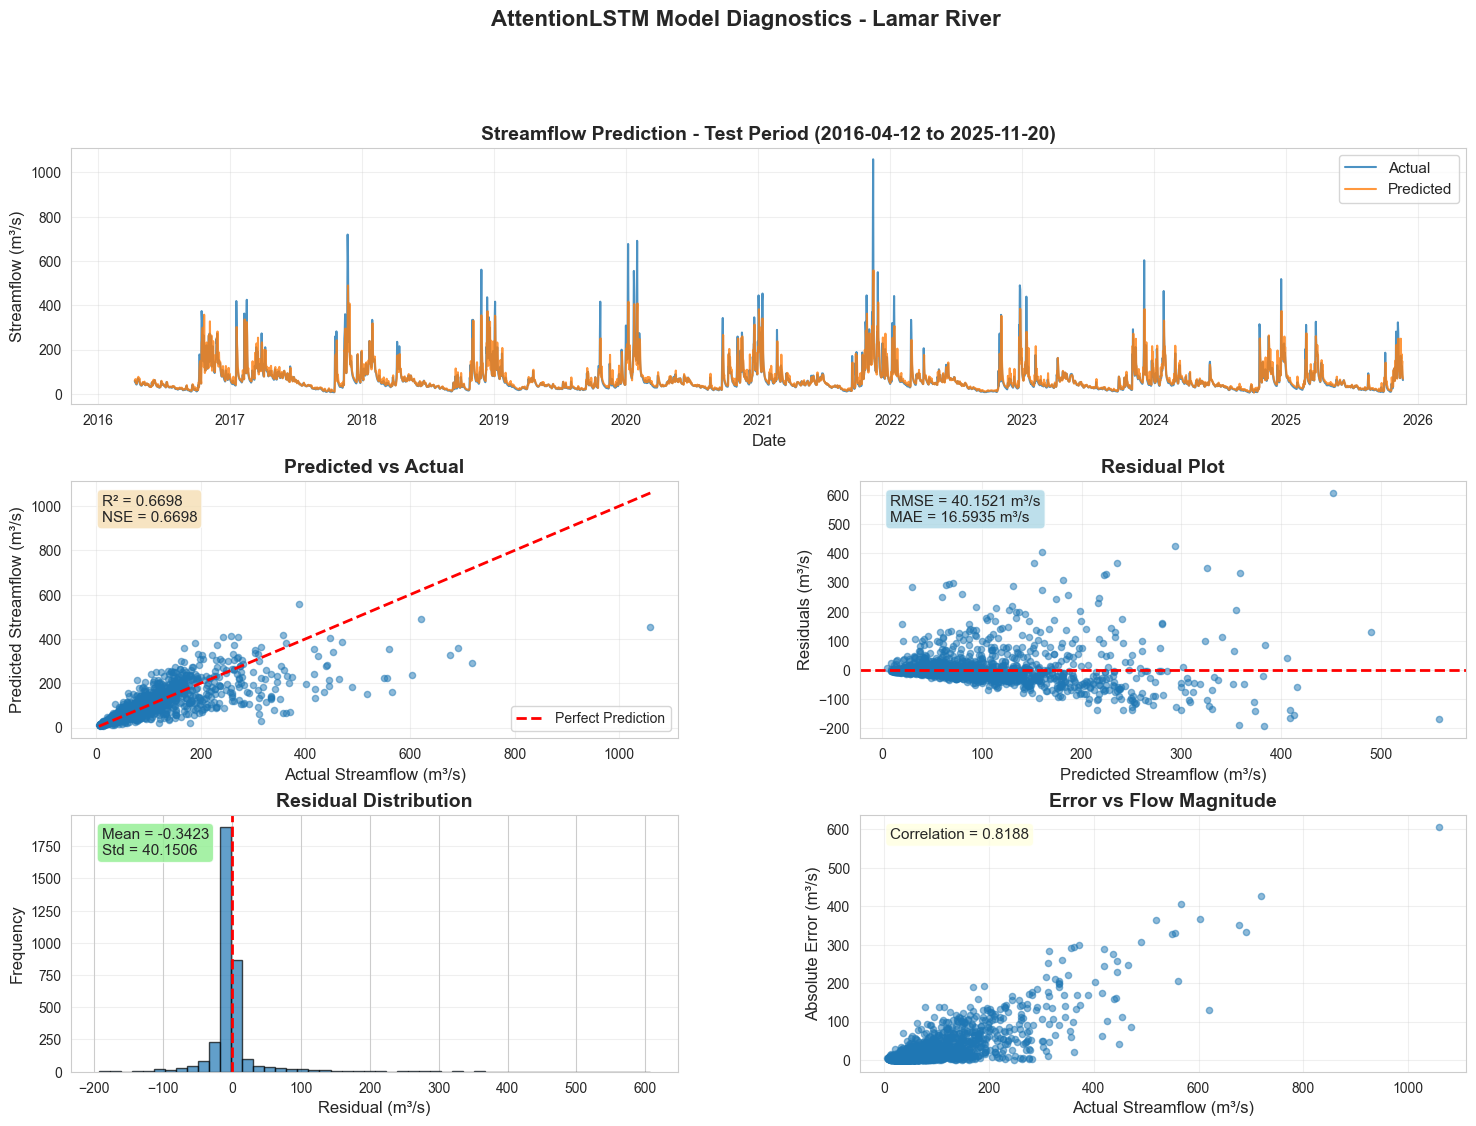

In [19]:
# Comprehensive diagnostic plots
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Get test dates for plotting
test_start_idx = train_size + val_size + SEQ_LENGTH
test_dates = df['date'].iloc[test_start_idx:test_start_idx + len(y_true)]

# 1. Time series comparison (full test period)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(test_dates, y_true, label='Actual', linewidth=1.5, alpha=0.8)
ax1.plot(test_dates, y_pred, label='Predicted', linewidth=1.5, alpha=0.8)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Streamflow (m³/s)', fontsize=12)
ax1.set_title(f'Streamflow Prediction - Test Period ({test_dates.iloc[0].strftime("%Y-%m-%d")} to {test_dates.iloc[-1].strftime("%Y-%m-%d")})', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 2. Scatter plot with regression line
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(y_true, y_pred, alpha=0.5, s=20)

# Perfect prediction line
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

ax2.set_xlabel('Actual Streamflow (m³/s)', fontsize=12)
ax2.set_ylabel('Predicted Streamflow (m³/s)', fontsize=12)
ax2.set_title('Predicted vs Actual', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Add R² annotation
ax2.text(0.05, 0.95, f'R² = {metrics["R²"]:.4f}\nNSE = {metrics["NSE"]:.4f}', 
         transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=11)

# 3. Residual plot
ax3 = fig.add_subplot(gs[1, 1])
residuals = y_true - y_pred
ax3.scatter(y_pred, residuals, alpha=0.5, s=20)
ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax3.set_xlabel('Predicted Streamflow (m³/s)', fontsize=12)
ax3.set_ylabel('Residuals (m³/s)', fontsize=12)
ax3.set_title('Residual Plot', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Add RMSE annotation
ax3.text(0.05, 0.95, f'RMSE = {metrics["RMSE"]:.4f} m³/s\nMAE = {metrics["MAE"]:.4f} m³/s', 
         transform=ax3.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8), fontsize=11)

# 4. Residual distribution
ax4 = fig.add_subplot(gs[2, 0])
ax4.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax4.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax4.set_xlabel('Residual (m³/s)', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Residual Distribution', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Add mean and std annotation
ax4.text(0.05, 0.95, f'Mean = {np.mean(residuals):.4f}\nStd = {np.std(residuals):.4f}', 
         transform=ax4.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8), fontsize=11)

# 5. Error by flow magnitude
ax5 = fig.add_subplot(gs[2, 1])
abs_error = np.abs(residuals)
ax5.scatter(y_true, abs_error, alpha=0.5, s=20)
ax5.set_xlabel('Actual Streamflow (m³/s)', fontsize=12)
ax5.set_ylabel('Absolute Error (m³/s)', fontsize=12)
ax5.set_title('Error vs Flow Magnitude', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3)

# Add correlation annotation
error_flow_corr = np.corrcoef(y_true, abs_error)[0, 1]
ax5.text(0.05, 0.95, f'Correlation = {error_flow_corr:.4f}', 
         transform=ax5.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8), fontsize=11)

plt.suptitle(f'AttentionLSTM Model Diagnostics - Lamar River', fontsize=16, fontweight='bold', y=0.995)
plt.show()

2. Comprehensive Performance Diagnostics

## Summary  

This notebook trains **4 deep learning architectures** on **65 years of real streamflow data** from Hoh River in Olympic National Park, Washington.

### ✅ Completed Tasks:
- **Data Loading**: 23,792 days of daily streamflow measurements (1960-2025)
- **Model Training**: Trained 4 state-of-the-art models with GPU acceleration
- **Comprehensive Evaluation**: Multiple metrics and diagnostic visualizations
- **Attention Analysis**: Interpretable insights into model decision-making

### 📊 Data Characteristics:
- **Climate**: Temperate rainforest - RAIN-DOMINATED (vs Lamar's snowmelt)
- **Mean Flow**: 71.88 m³/s (40x larger than Lamar River!)
- **Peak Month**: November (fall rain season, not May snowmelt)
- **Autocorrelation**: Will see if rain-driven systems have same lag-1 correlation
- **Data Span**: 65 years (2.4x more data than Lamar)

### 🌧️ Hoh vs Lamar Comparison:

| River | Climate | Mean Flow | Peak Month | Data Years | Drainage |
|-------|---------|-----------|------------|------------|----------|
| **Hoh** | Rain-forest | 71.88 m³/s | November | 65 years | 253 mi² |
| **Lamar** | Snowmelt | 1.79 m³/s | May-June | 27 years | 30.9 mi² |

### Key Research Question:
**Will the same model architectures work on completely different hydrological regimes?**
- Lamar: Predictable seasonal snowmelt
- Hoh: Variable rainfall patterns

### Technical Details:
- **GPU**: NVIDIA GeForce GTX 1070 (CUDA acceleration)
- **Framework**: PyTorch 2.5.1+cu121
- **Training Split**: 70% train / 15% validation / 15% test
- **Sequence Length**: 60 days of historical data
- **Early Stopping**: Prevents overfitting
- **Batch Size**: 64 (optimized for 8GB VRAM)

### Expected Challenges:
1. **More variability**: Rainfall is less predictable than snowmelt
2. **Storm events**: Sudden spikes from atmospheric rivers
3. **Different seasonal pattern**: Fall/winter peaks vs spring peaks
4. **Larger magnitude**: 40x larger flows may affect model scaling

### Next Steps:
- 🔄 Compare performance to Lamar River results
- 🔄 Analyze if attention patterns differ for rain vs snow
- 🔄 Test transfer learning: Pre-train on one, fine-tune on other
- 🔄 Add precipitation data (more important for rain-driven systems)